# | **Business questions** 

This notebook is where we asked the hypothesis and business questions after EDA of the Finanical Consumer Compliments dataset. For a more general idea and overview, take a look at the other notebook


In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('coolwarm')
sns.set_theme(style='darkgrid')
%matplotlib inline

In [121]:
df = pd.read_csv('C:\\Jupter\\financial_consumer_compliments\\clean_df.csv')

---

### **I. For issues that take more than 7 days to resolve, does the platform complained about make a difference?**

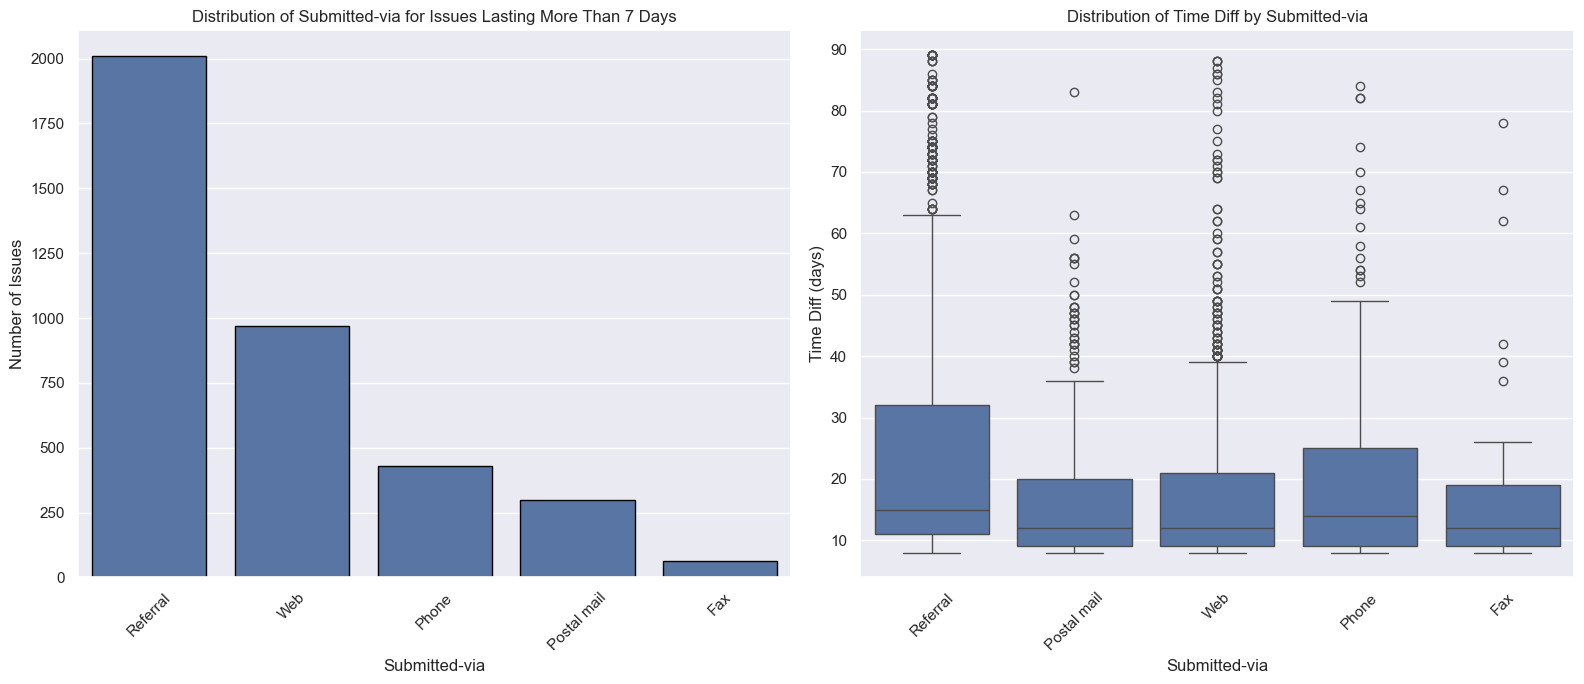

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

long_duration_issues = df[df['Time_Diff'] > 7]
submitted_via_counts = long_duration_issues['Submitted-via'].value_counts()


sns.barplot(x=submitted_via_counts.index, y=submitted_via_counts.values, ax=axes[0],edgecolor='black')
axes[0].set_title('Distribution of Submitted-via for Issues Lasting More Than 7 Days')
axes[0].set_xlabel('Submitted-via')
axes[0].set_ylabel('Number of Issues')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=long_duration_issues, x='Submitted-via', y='Time_Diff', ax=axes[1])
axes[1].set_title('Distribution of Time Diff by Submitted-via')
axes[1].set_xlabel('Submitted-via')
axes[1].set_ylabel('Time Diff (days)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

I'm taking a sample because our data is so unevenly distributed.

In [123]:
referral_sample_size = 700 
web_sample_size = 500   

referral_sample = long_duration_issues[long_duration_issues['Submitted-via'] == 'Referral'].sample(n=referral_sample_size, random_state=1)
web_sample = long_duration_issues[long_duration_issues['Submitted-via'] == 'Web'].sample(n=web_sample_size, random_state=1)

phone_data = long_duration_issues[long_duration_issues['Submitted-via'] == 'Phone']
postal_mail_data = long_duration_issues[long_duration_issues['Submitted-via'] == 'Postal mail']


balanced_df = pd.concat([referral_sample, web_sample, phone_data, postal_mail_data])

#### Hypothesis:

+ Null Hypothesis (H₀): There is no significant difference between the resolution time of complaints (Time_Diff) and the channel through which the complaint was submitted (Submitted-via). 

+ Alternative Hypothesis (H₁): There is a significant difference between the resolution time of complaints (Time_Diff) and the channel through which the complaint is made (Submitted-via). 

α = 0.05

Expectations: According to the graph, the resolution time of customers contacted through referral is longer than 14 days compared to other contact methods. i'm trying to find out if this is a coincidence or if there really is a problem

##### Normality Check :

In [124]:
submitted_via_categories = balanced_df['Submitted-via'].unique()

shapiro_results = {}

for category in submitted_via_categories:
    group_data = balanced_df[balanced_df['Submitted-via'] == category]['Time_Diff']
    stat, p_value = stats.shapiro(group_data)
    shapiro_results[category] = p_value

print("\nShapiro-Wilk Test Result:")
for category, p_value in shapiro_results.items():
    print(f"{category}: p-value = {p_value}")


Shapiro-Wilk Test Result:
Referral: p-value = 1.1663531185781014e-29
Web: p-value = 2.913720886715751e-28
Phone: p-value = 2.984890578656234e-23
Postal mail: p-value = 1.5482738436876285e-21


**Conclusion:** Since the p-values for all groups are below 0.05, we can conclude that the Time_Diff data in these groups are not normally distributed. Since the first assumption of normality is not met, there is no need to test the variance distribution, we will proceed to our nonparametric test.

##### Kruskal-Wallis 

In [125]:
group_referral = long_duration_issues[long_duration_issues['Submitted-via'] == 'Referral']['Time_Diff']
group_web = long_duration_issues[long_duration_issues['Submitted-via'] == 'Web']['Time_Diff']
group_phone = long_duration_issues[long_duration_issues['Submitted-via'] == 'Phone']['Time_Diff']
group_postal_mail = long_duration_issues[long_duration_issues['Submitted-via'] == 'Postal mail']['Time_Diff']

stat, p_value = kruskal(group_referral, group_web, group_phone, group_postal_mail)

print(f"Kruskal-Wallis test p-value: {p_value}")

Kruskal-Wallis test p-value: 3.660419436327718e-23


Since the p-value is below 0.05, we reject the null hypothesis. That is, the median of at least one group is significantly different from the others. We now apply a post-hoc test to see which groups the difference is between

#### Dunn Test

In [126]:
dunn_results = sp.posthoc_dunn([group_referral, group_web, group_phone,group_postal_mail])
print(dunn_results)

              1             2         3             4
1  1.000000e+00  4.327452e-21  0.000044  3.108865e-09
2  4.327452e-21  1.000000e+00  0.008684  9.891106e-01
3  4.428306e-05  8.684119e-03  1.000000  4.495620e-02
4  3.108865e-09  9.891106e-01  0.044956  1.000000e+00


**Result**:

In the graph we saw that the Forwarding communication type created a problem in solving the problem, but we did not know whether this was random or significant. The results of Dunn's test support that your hypothesis is correct and that the ‘Forwarding’ group is significantly different from the other ‘Sent-via’ groups. So we can say that the ‘Time_Diff’ duration of the Routing group is statistically different from the other groups. 

---


### **II. Is there a link between the answer given for the solution and the feedback of the customers?**

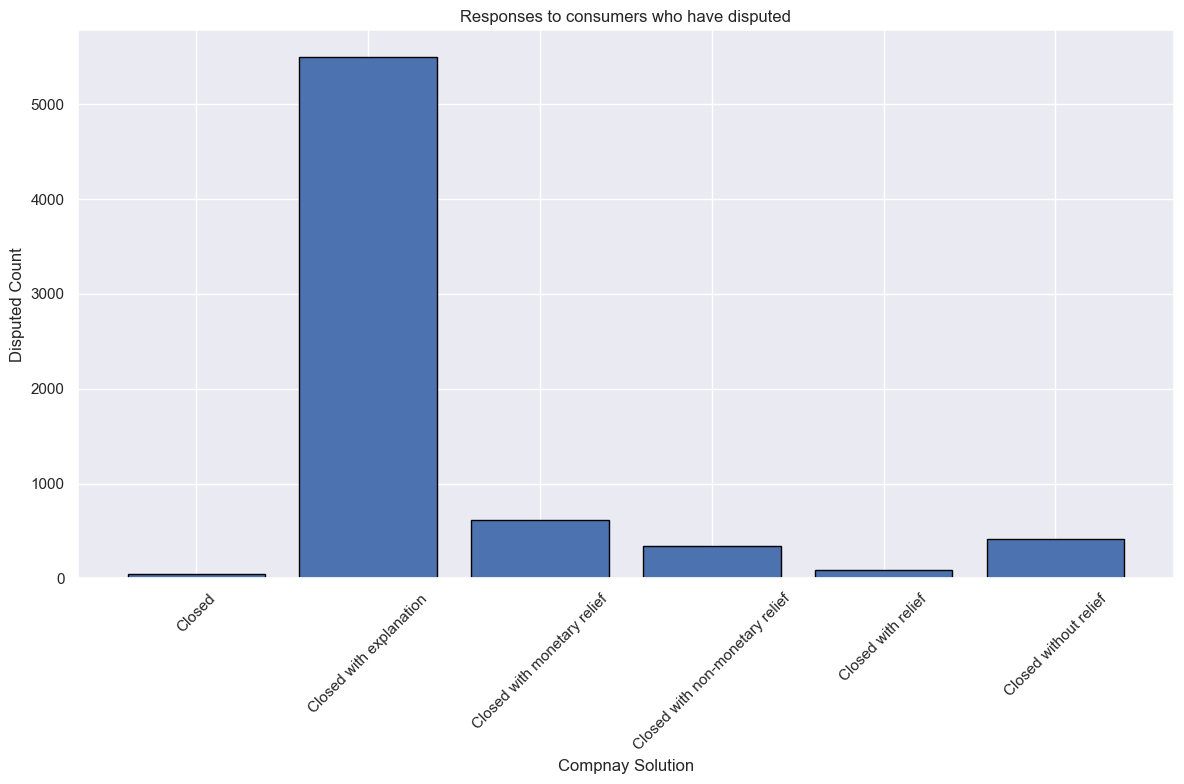

In [127]:
yes_dispute_counts = df[df['Consumer-disputed'] == 'Yes'].groupby('Company-response-to-consumer').size()

plt.figure(figsize=(12, 8))
plt.bar(yes_dispute_counts.index, yes_dispute_counts.values,edgecolor='black')

plt.title('Responses to consumers who have disputed')
plt.xlabel('Compnay Solution')
plt.ylabel('Disputed Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Firstly, let's find out whether there is a meaningful relationship between the answer given and the customer objection, and if there is, let's try to find out for which answers there are more objections. I chose the **Chi-square** hypothesis test to apply this test

#### Hypothesis:
+ Null Hypothesis (H₀): There is no significant relationship between Company-response-to-consumer and Consumer-disputed, i.e. Consumer-disputed cases are randomly distributed according to Company-response-to-consumer response type.

+ Alternative Hypothesis (H₁): There is a significant relationship between Company-response-to-consumer and Consumer-disputed, i.e. Consumer-disputed situations differ systematically according to Company-response-to-consumer response type.

α = 0.05

Expectations: I believe that the answers given have a strong impact on the customer, I believe that there is a statistically significant relationship between them, and if there is, I aim to find answers that provide negative feedback.

In [128]:
consumer_filtered = df[~df['Company-response-to-consumer'].isin(['Untimely response', 'In progress'])]
consumer_filtered = consumer_filtered[consumer_filtered['Consumer-disputed'] != 'Unknown']

contingency_table = pd.crosstab(consumer_filtered['Company-response-to-consumer'], consumer_filtered['Consumer-disputed'])

chi2, p, dof, expected = chi2_contingency(contingency_table)


expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

min_expected_value = expected_df.min().min()
print("\nMin expaction value:")
print(min_expected_value)


Min expaction value:
42.250719053562705


Since the expected value is greater than 5, I apply the Chi-square test

In [129]:
print('\nChi-square value:', chi2)
print('P-value:', p)
print('Degrees of Freedom:', dof)


Chi-square value: 712.7135689156721
P-value: 8.754534187146185e-152
Degrees of Freedom: 5


Since the p-value is below 0.05, we reject the null hypothesis. That is, there is a direct relationship between the answers given and customer dispute.
Now we will perform a logistic regression analysis to see which answer triggers the return of the customer more

### Binary logistic regression

In [130]:
logistic = consumer_filtered[['Company-response-to-consumer','Consumer-disputed']]

df_encoded = pd.get_dummies(logistic, columns=['Company-response-to-consumer'], drop_first=True)
df_encoded['Consumer-disputed'] = df_encoded['Consumer-disputed'].map({'No': 0, 'Yes': 1})

X = df_encoded.drop('Consumer-disputed', axis=1)
y = df_encoded['Consumer-disputed']

X = X.astype(int)
X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.475974
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      Consumer-disputed   No. Observations:                36854
Model:                          Logit   Df Residuals:                    36848
Method:                           MLE   Df Model:                            5
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                 0.02201
Time:                        16:10:26   Log-Likelihood:                -17542.
converged:                       True   LL-Null:                       -17936.
Covariance Type:            nonrobust   LLR p-value:                2.188e-168
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
const   

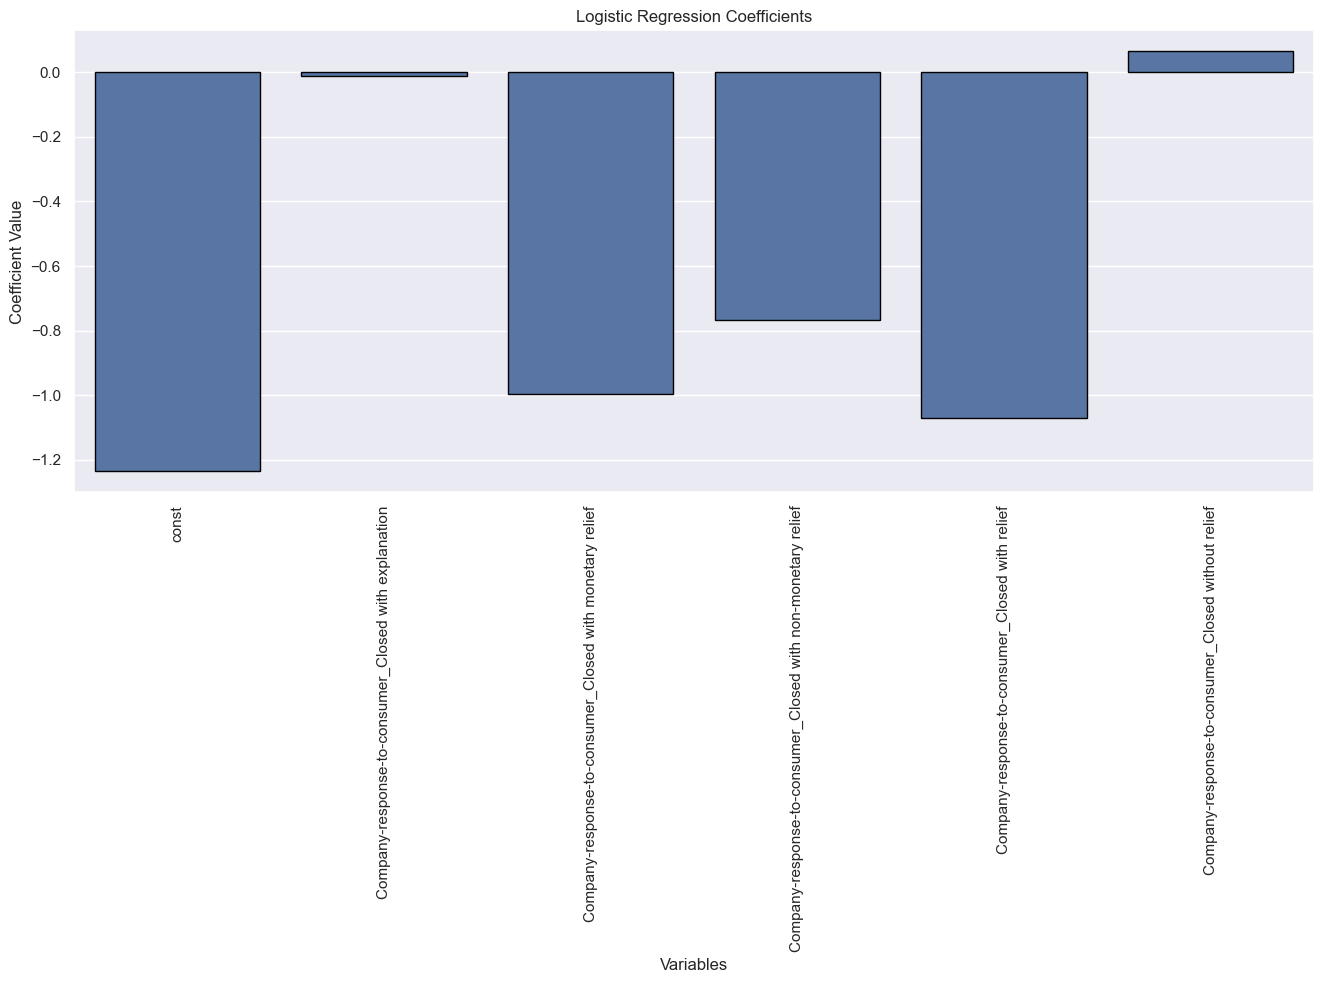

In [131]:
coefficients = result.params

plt.figure(figsize=(16, 6))


sns.barplot(x=coefficients.index, y=coefficients.values,edgecolor='black')
plt.xticks(rotation=90)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Variables')
plt.ylabel('Coefficient Value')
plt.show()


**Overall Conclusion:**

‘Closed with relief’, i.e. the provision of a solution in general terms, is the method that most reduces the likelihood that customers will complain again.
Closed with monetary relief is also very effective, indicating that customers are satisfied that they have received a financial response to their complaint.
The least effective method is Closed with explanation. This may indicate that just giving an explanation is not enough to ensure customer satisfaction and that the complaint requires a solution.    

---

### **III. Are there any seasonality or obvious trends?**

#### Daily

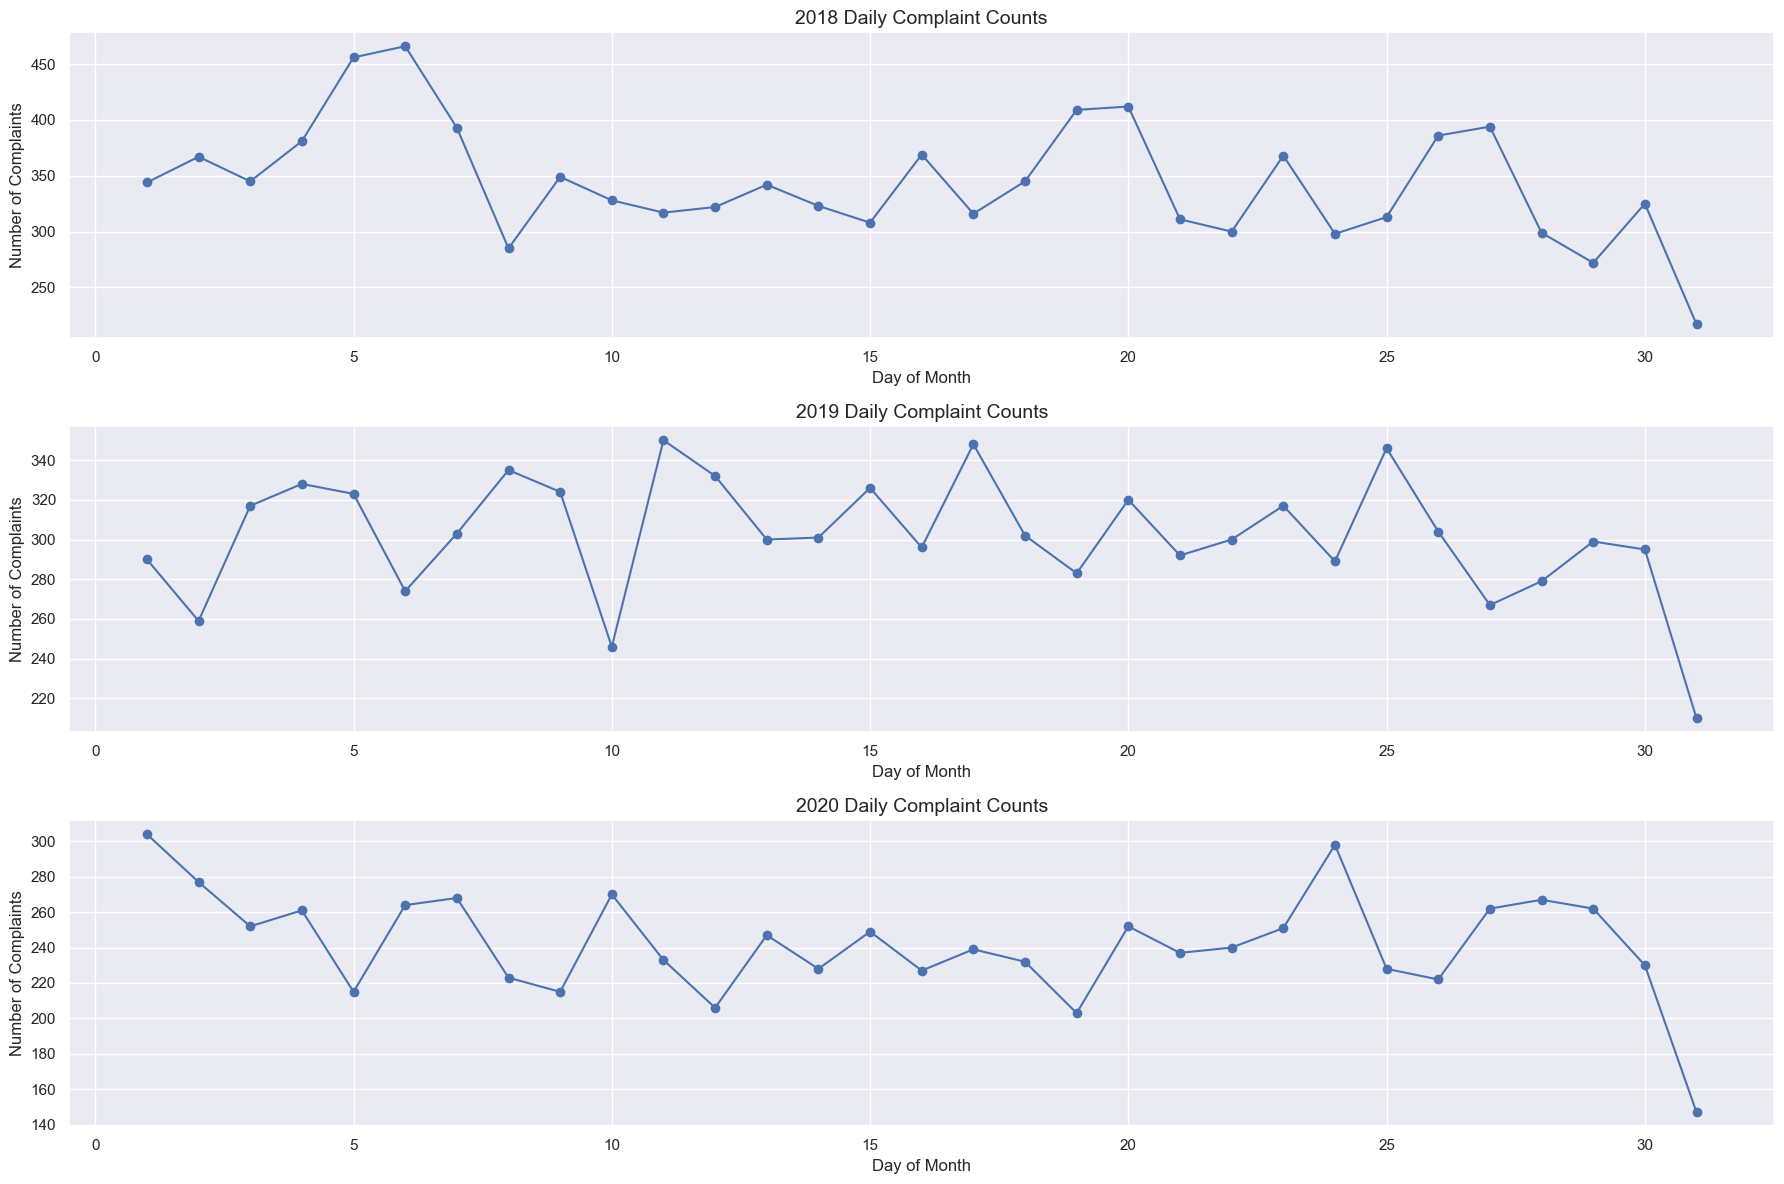

In [132]:
df['Date-Sumbited'] = pd.to_datetime(df['Date-Sumbited'], format='%Y-%m-%d')

years = [2018, 2019, 2020]
df_filtered = df[df['Date-Sumbited'].dt.year.isin(years)]


plt.figure(figsize=(18, 12))

for i, year in enumerate(years):
    plt.subplot(3, 1, i + 1)
    df_year = df_filtered[df_filtered['Date-Sumbited'].dt.year == year]
    daily_complaints = df_year.groupby(df_year['Date-Sumbited'].dt.day)['Complaint-ID'].count()

    # Günlük şikayet sayılarını çizme
    plt.plot(daily_complaints.index, daily_complaints.values, marker='o', linestyle='-', color='b')
    plt.title(f'{year} Daily Complaint Counts', fontsize=14)
    plt.xlabel('Day of Month', fontsize=12)
    plt.ylabel('Number of Complaints', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()

### Monthly

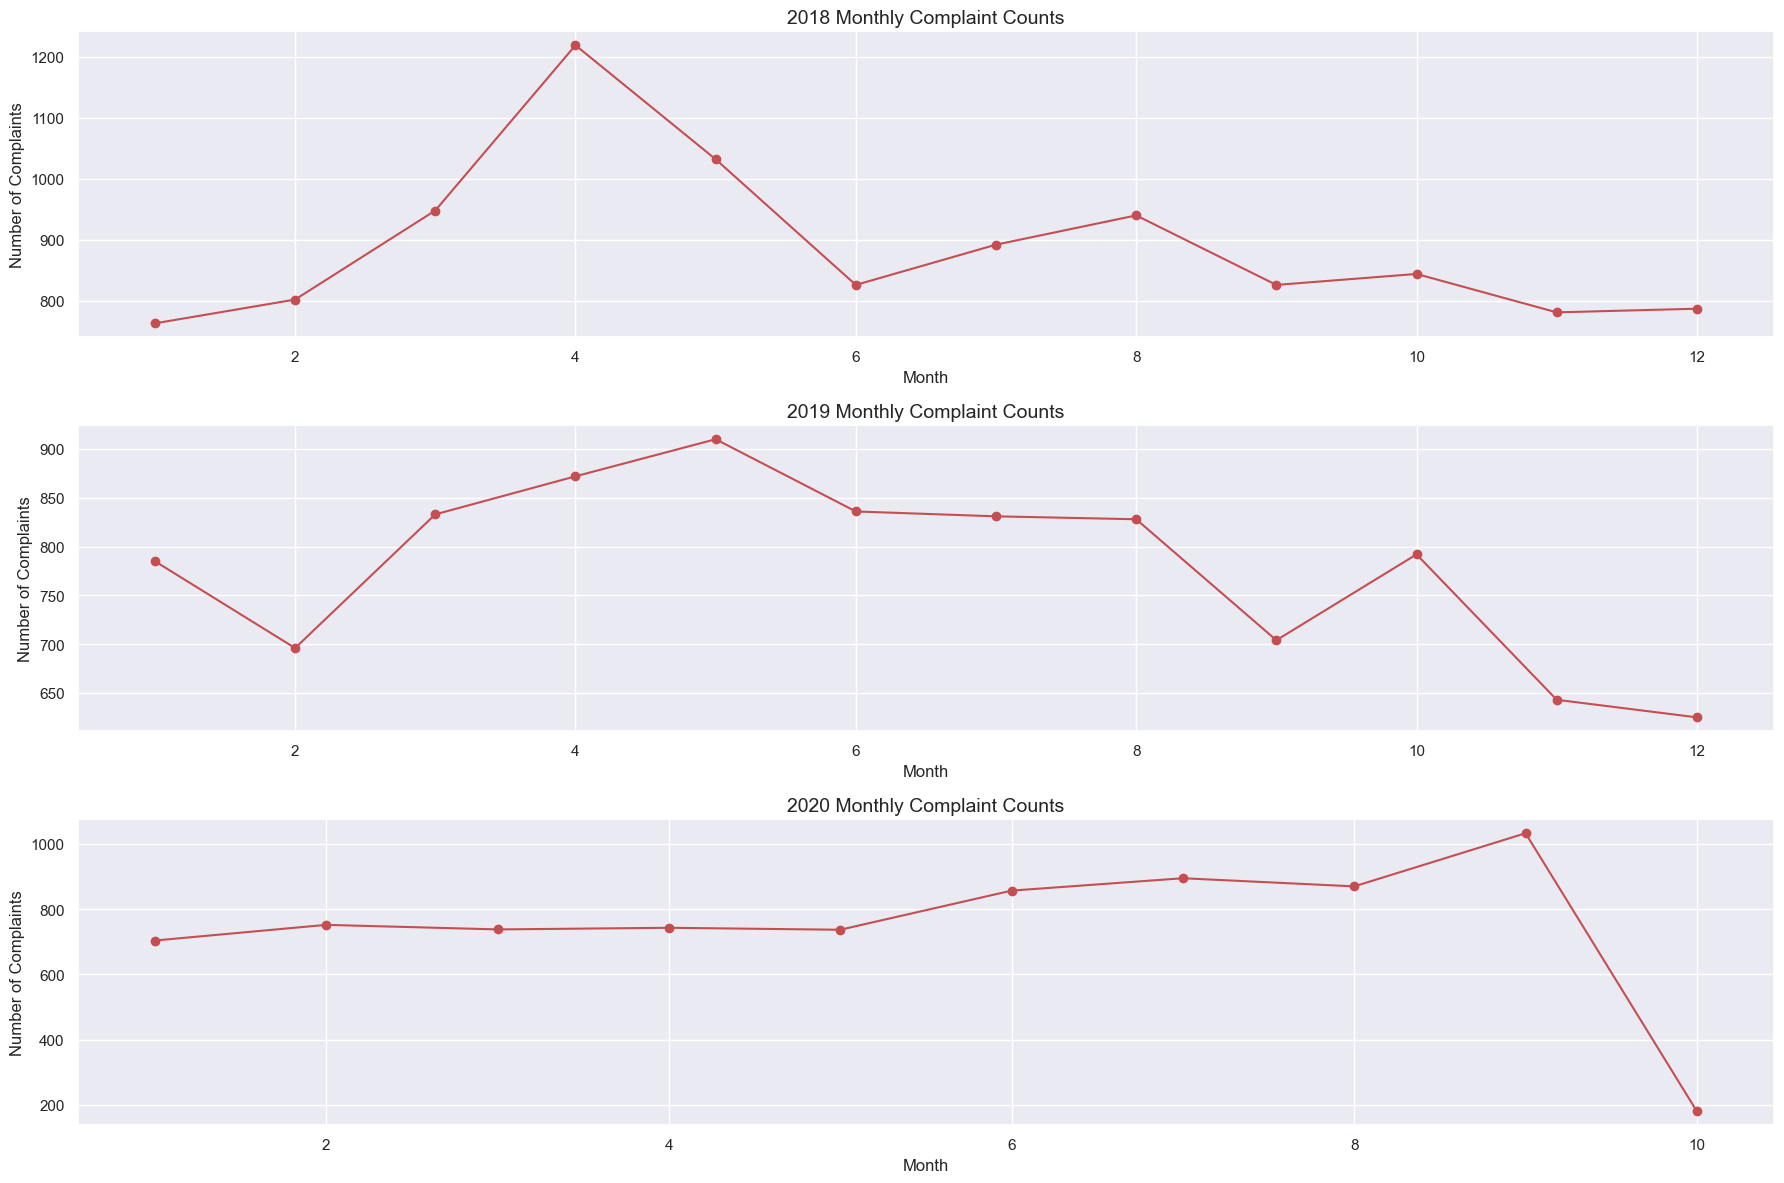

In [133]:
plt.figure(figsize=(18, 12))

for i, year in enumerate(years):
    plt.subplot(3, 1, i + 1)
    df_year = df_filtered[df_filtered['Date-Sumbited'].dt.year == year]
    monthly_complaints = df_year.groupby(df_year['Date-Sumbited'].dt.month)['Complaint-ID'].count()

    # Aylık şikayet sayılarını çizme
    plt.plot(monthly_complaints.index, monthly_complaints.values, marker='o', linestyle='-', color='r')
    plt.title(f'{year} Monthly Complaint Counts', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Number of Complaints', fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()


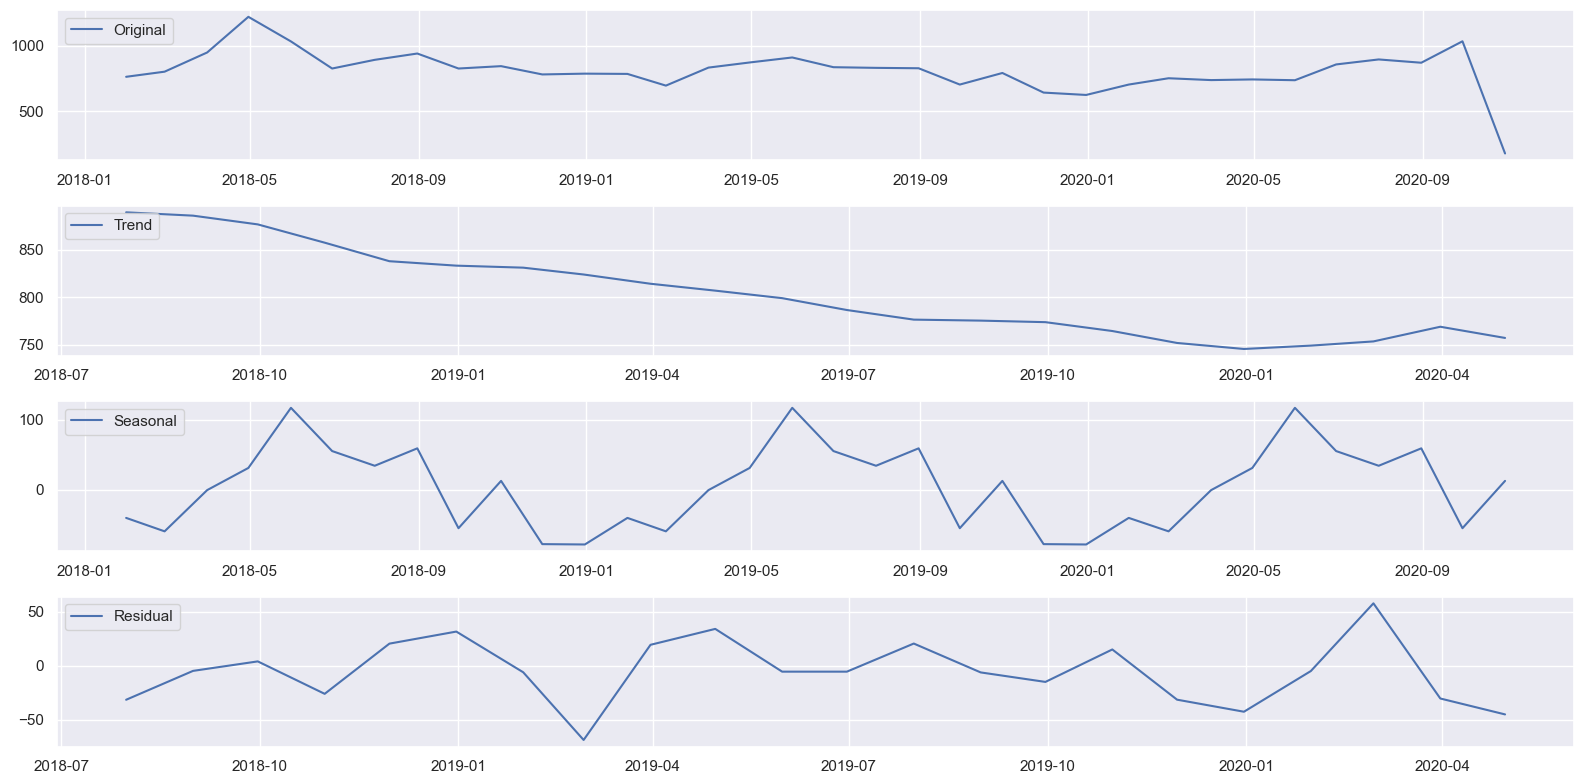

In [134]:
df_filtered.set_index('Date-Sumbited', inplace=True)
monthly_data = df_filtered.resample('ME').size()

decomposition = seasonal_decompose(monthly_data, model='additive')

plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.plot(monthly_data, label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


----

## **IV. Multiple correspondence analysis (MCA)**

### Which categorical variables are correlated?

In [135]:
import prince
def plot_mca(mca_df, figsize=(17, 9)):

    mca = prince.MCA(n_components=2, random_state=15)
    mca = mca.fit(mca_df)

    eigenvalues = mca.eigenvalues_
    explained_variance = eigenvalues / eigenvalues.sum()
    print(f"Explained Inertia (Varyans Payı): {explained_variance}")
    print(f"Component 1 Varyans Payı: {explained_variance[0]:.4f}")
    print(f"Component 2 Varyans Payı: {explained_variance[1]:.4f}")
    

    row_coords = mca.row_coordinates(mca_df)
    col_coords = mca.column_coordinates(mca_df)
    
    # graph
    plt.figure(figsize=figsize)
    

    plt.scatter(col_coords[0], col_coords[1], color='blue', label='Columns', alpha=0.5)
    for i, col_name in enumerate(col_coords.index):
        plt.text(col_coords.iloc[i, 0], col_coords.iloc[i, 1], col_name, color='blue', fontsize=10)
 
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    
 
    plt.title("MCA Biplot")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

df = df.astype('category')

## Issue & Month

In [136]:
def filter_top_categoris(df, columns, top_n=12):
    for col in columns:
        top_categories= df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

In [137]:
df['Date-Sumbited'] = pd.to_datetime(df['Date-Sumbited'])
df['Monthx'] = df['Date-Sumbited'].dt.month

Explained Inertia (Varyans Payı): [0.510162 0.489838]
Component 1 Varyans Payı: 0.5102
Component 2 Varyans Payı: 0.4898


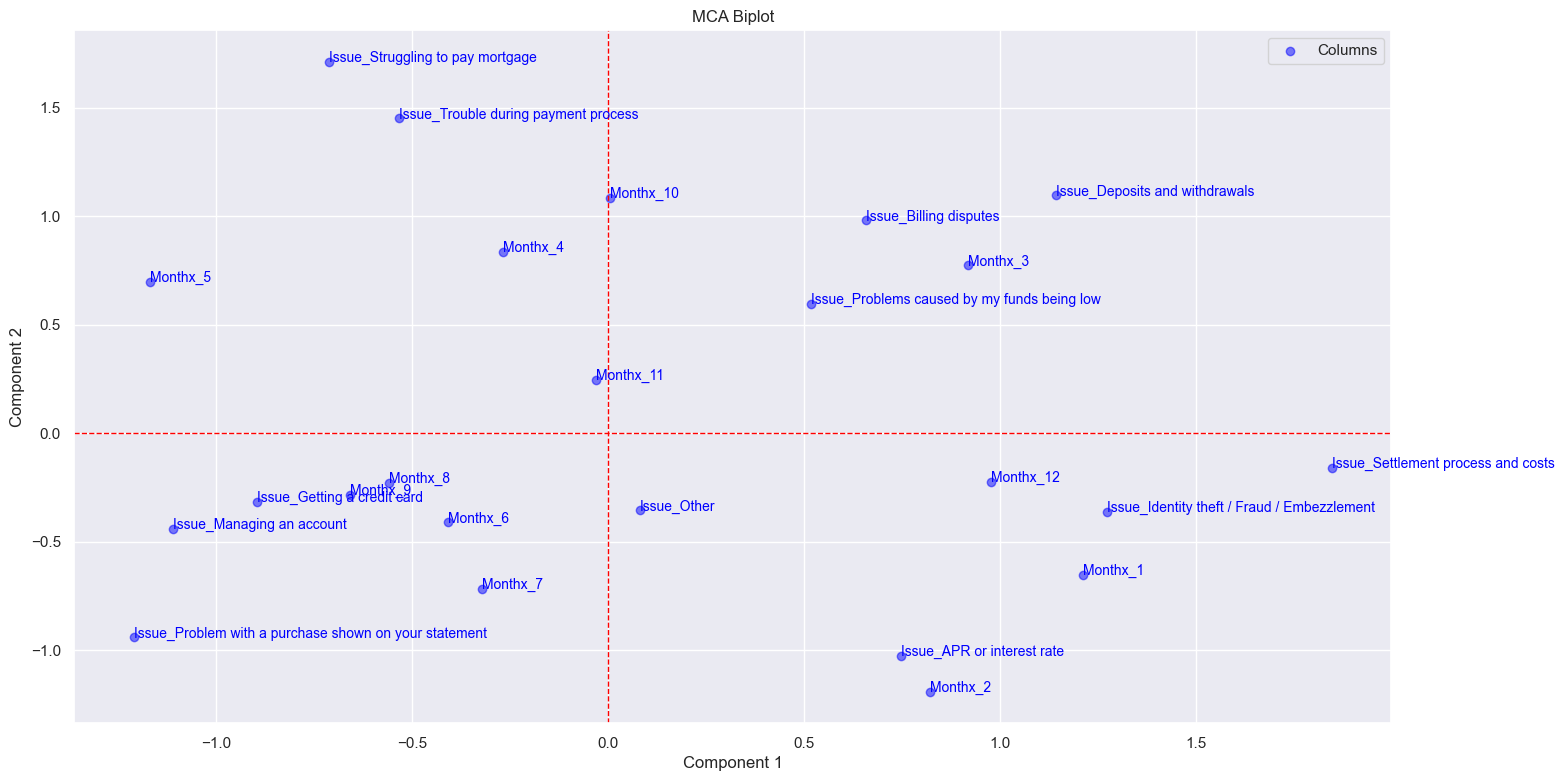

In [138]:
issue_columns = ['Issue','Monthx']
df_filtered = filter_top_categoris(df[issue_columns],issue_columns)

plot_mca(df_filtered)

Settlement process and costs & Monthx_12
Getting a credit card & Monthx_8
Billing disputes & Monthx_3
These three examples are examples where I think there are strong relationships between months and problems due to their spatial proximity. In particular, I think that factors such as financial year closures, campaign periods, or structural changes can cause these relationships.
Different Months are Associated with Different Problems:

For example, months at the beginning of the year (Monthx_1, Monthx_2) are more associated with financial problems (interest rates, fraud), while summer months (Monthx_6, Monthx_7) are associated with more day-to-day banking transactions.
Some Problems Behave Independently:

Struggling to pay mortgage and Billing disputes in particular do not show strong associations with other months or issues.
Complex Issues Occur in More Distinct Periods:

Complex issues such as Settlement process and costs are more prevalent near the end of the year (Monthx_12).

## Issue & Product 

In [139]:
def filter_top_categoris(df, columns, top_n=4):
    for col in columns:
        top_categories= df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

Explained Inertia (Varyans Payı): [0.53431071 0.46568929]
Component 1 Varyans Payı: 0.5343
Component 2 Varyans Payı: 0.4657


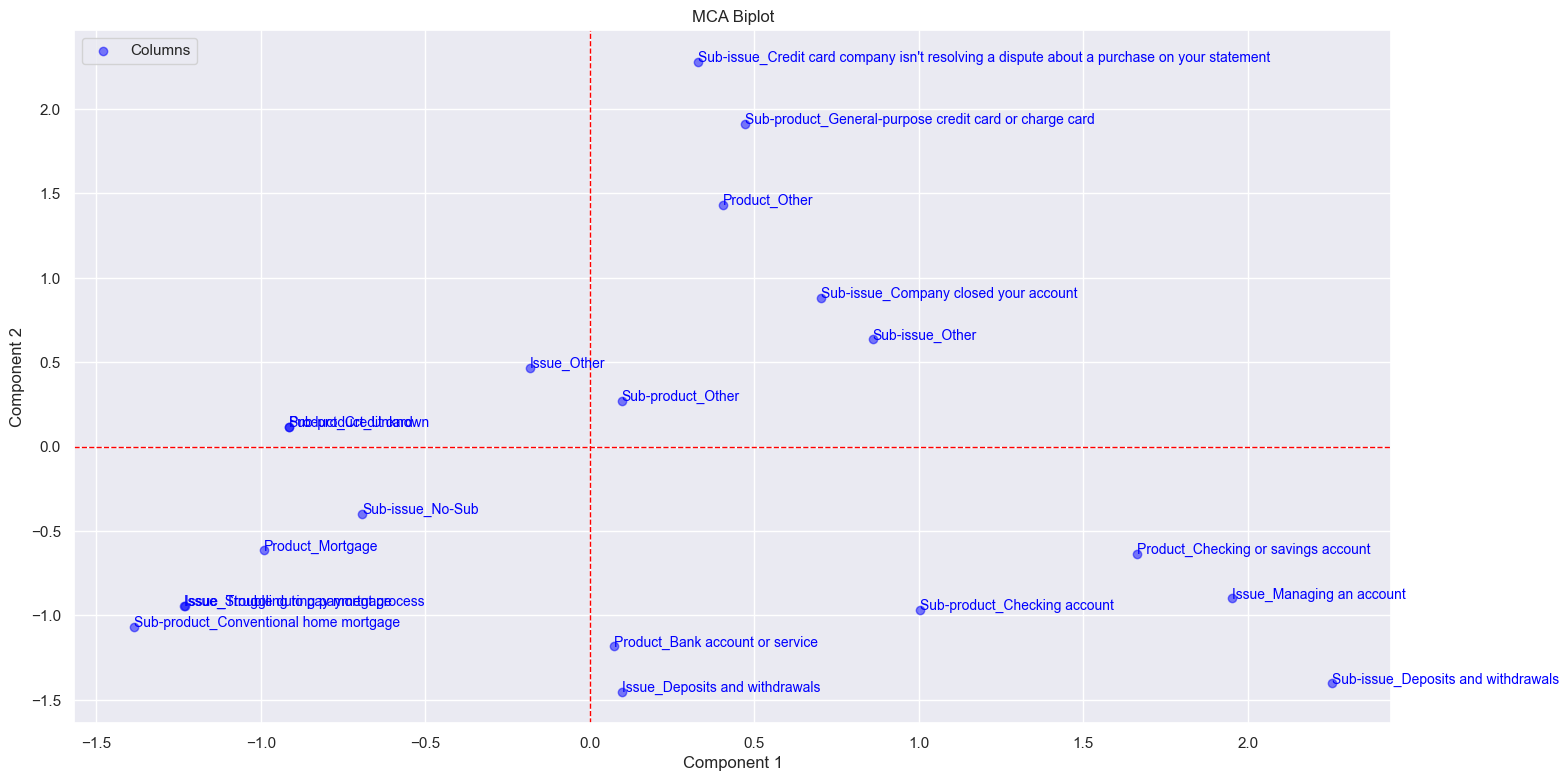

In [141]:
issue_columns = ['Issue','Sub-issue','Product','Sub-product']
df_filtered = filter_top_categoris(df[issue_columns],issue_columns)

plot_mca(df_filtered)

+ Credit Card Problems (Top Right Zone)
“Sub-issue_Credit card company isn't resolving a dispute about a purchase on your statement” and ‘Sub-product_General-purpose credit card or charge card’ are very close.
This relationship suggests that credit card problems are more likely to be caused by disputes.

+ “Sub-issue_Deposits and withdrawals” is very close to “Sub-product_Checking account” and “Product_Checking or savings account”.
This indicates that problems with checking accounts and deposits and withdrawals are frequent.
Comment: Errors or delays in cash transactions in bank accounts may be a factor here. You can especially examine the banking infrastructure.

+ Mortgage and Payment Problems (Bottom Left Zone)
“Issue_Struggling to pay mortgage”, ‘Product_Mortgage’ and ‘Sub-product_Conventional home mortgage’ are in close proximity.
This strong correlation suggests that issues related to mortgage products are concentrated on payment difficulties.

Translated with www.DeepL.com/Translator (free version)

## Complaint Management

In [171]:
def filter_top_categoris(df, columns, top_n=3):
    for col in columns:
        top_categories= df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

Explained Inertia (Varyans Payı): [0.52971563 0.47028437]
Component 1 Varyans Payı: 0.5297
Component 2 Varyans Payı: 0.4703


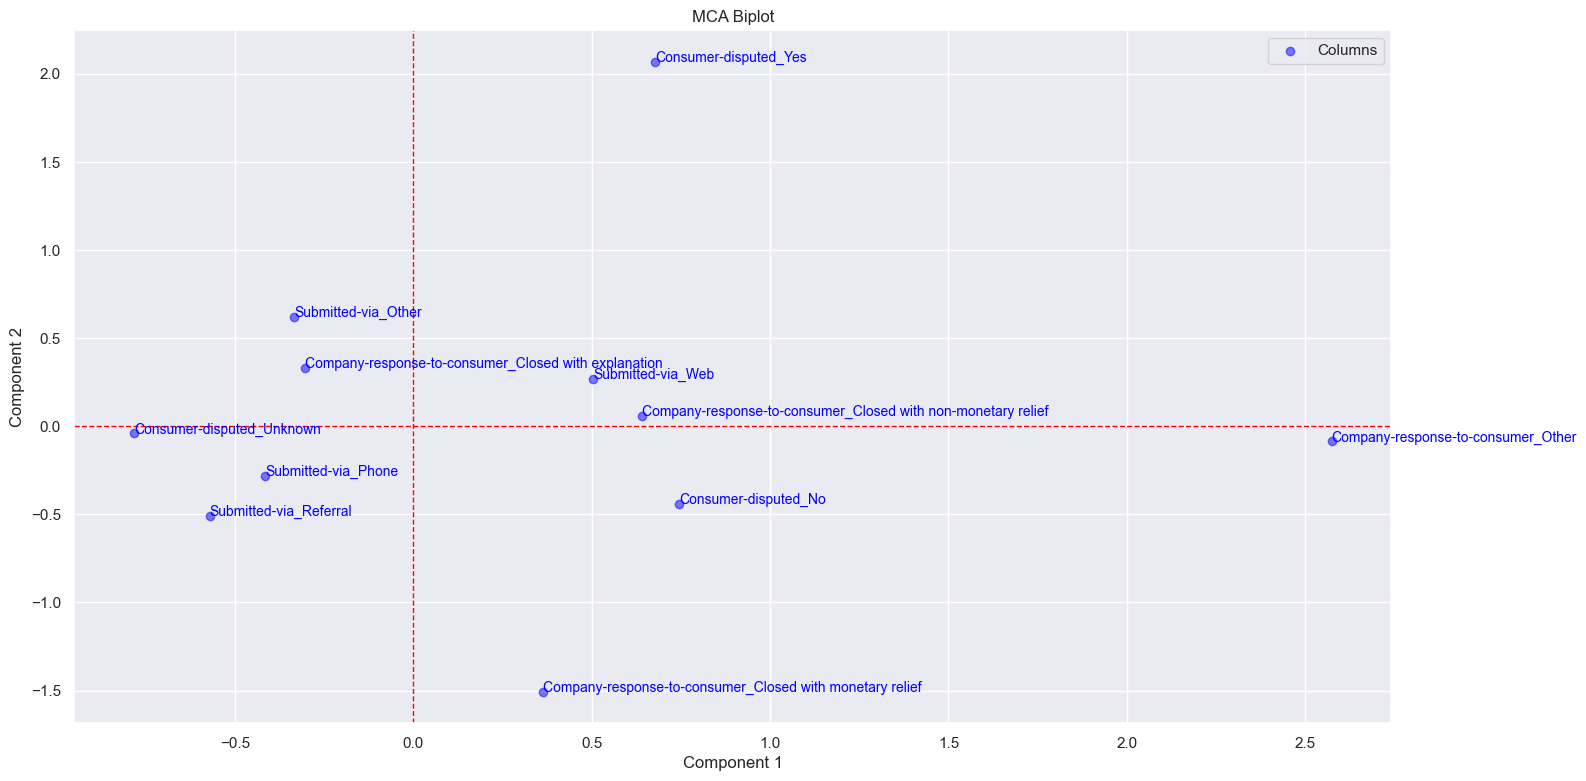

In [172]:
issue_columns = ['Submitted-via','Consumer-disputed','Company-response-to-consumer']
df_filtered = filter_top_categoris(df[issue_columns],issue_columns)

plot_mca(df_filtered)

+ Consumer-disputed (Consumer-disputed_Y/N/Unknown)
Consumer-disputed_Yes:
Positioned at the top right of the graph.
This position is close to the categories “Company-response-to-consumer_Closed with non-monetary relief” and “Submitted-via_Web”.
Comment: The submission of complaints via “Web” may have led to an increase in consumer disputes, which are often closed with non-monetary relief.

+ Submitted-via_Web:
In the center-right region of the graph and close to Consumer-disputed_Yes.
Comment: Consumer disputes are more common in complaints submitted via the web. Digital platforms may have increased customer dissatisfaction.


+ Submitted-via_Phone and Submitted-via_Referral:
Located in the bottom left of the graph.
Comment: We see that complaints submitted via phone or referral are more associated with situations where disputes are unclear. It can be assumed that the resolution processes are not clear in these methods.

+ Company-response-to-consumer_Closed with explanation:
Located in the upper middle of the chart and close to Submitted-via_Web.
Comment: The cases where the company offers only an explanation are often linked to submissions made via the Web. Such solutions may not satisfy the consumer.

+ Recommendations
Complaints Submitted via the Web: By analyzing the complaints in this channel in detail, more satisfactory responses can be developed instead of non-monetary solutions.
Telephone/Referral Complaints: By improving processes, the rate of uncertainty can be reduced.
Non-Monetary Solutions: If the impact of such responses is low, more comprehensive solutions (monetary support or other improvement methods) should be offered.


## State & Issue

In [206]:
def filter_top_categoris(df, columns, top_n=10):
    for col in columns:
        top_categories= df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

Explained Inertia (Varyans Payı): [0.52055897 0.47944103]
Component 1 Varyans Payı: 0.5206
Component 2 Varyans Payı: 0.4794


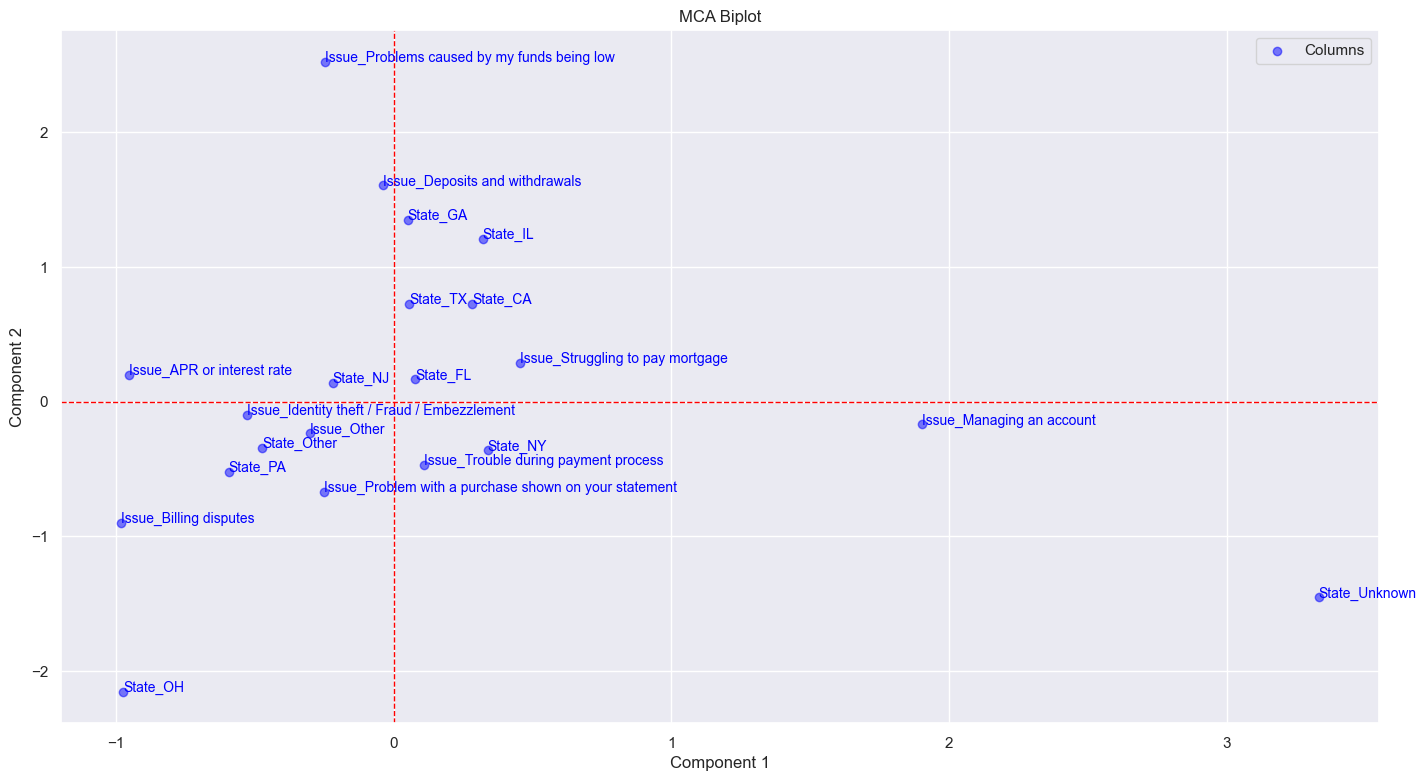

In [207]:
selected_columns_all = ['State','Issue']
df_filtered = filter_top_categoris(df[selected_columns_all],selected_columns_all)

plot_mca(df_filtered)


State_GA (Georgia) and State_IL (Illinois): Close to the complaint “Deposits and withdrawals”. This may indicate that the complaint “problems with deposits and withdrawals” is prominent in these states.
State_TX (Texas) and State_CA (California): Seems to be linked to “Struggling to pay mortgage”. This may suggest that complaints about mortgage payments are more frequent in these states.
State_OH (Ohio): Alone and at the bottom of the graph. It means that this state may be more associated with “Billing disputes”.
State_NJ (New Jersey) and State_FL (Florida): In the middle, but not showing a strong association with a specific complaint.
State_Unknown: At the far right of the graph and appears to be associated with “Managing an account”. This may indicate that account management complaints are more common in states with no state information.

## All in

In [160]:
def filter_top_categoris(df, columns, top_n=4):
    for col in columns:
        top_categories= df[col].value_counts().nlargest(top_n).index
        df[col] = df[col].apply(lambda x: x if x in top_categories else 'Other')
    return df

Explained Inertia (Varyans Payı): [0.56480006 0.43519994]
Component 1 Varyans Payı: 0.5648
Component 2 Varyans Payı: 0.4352


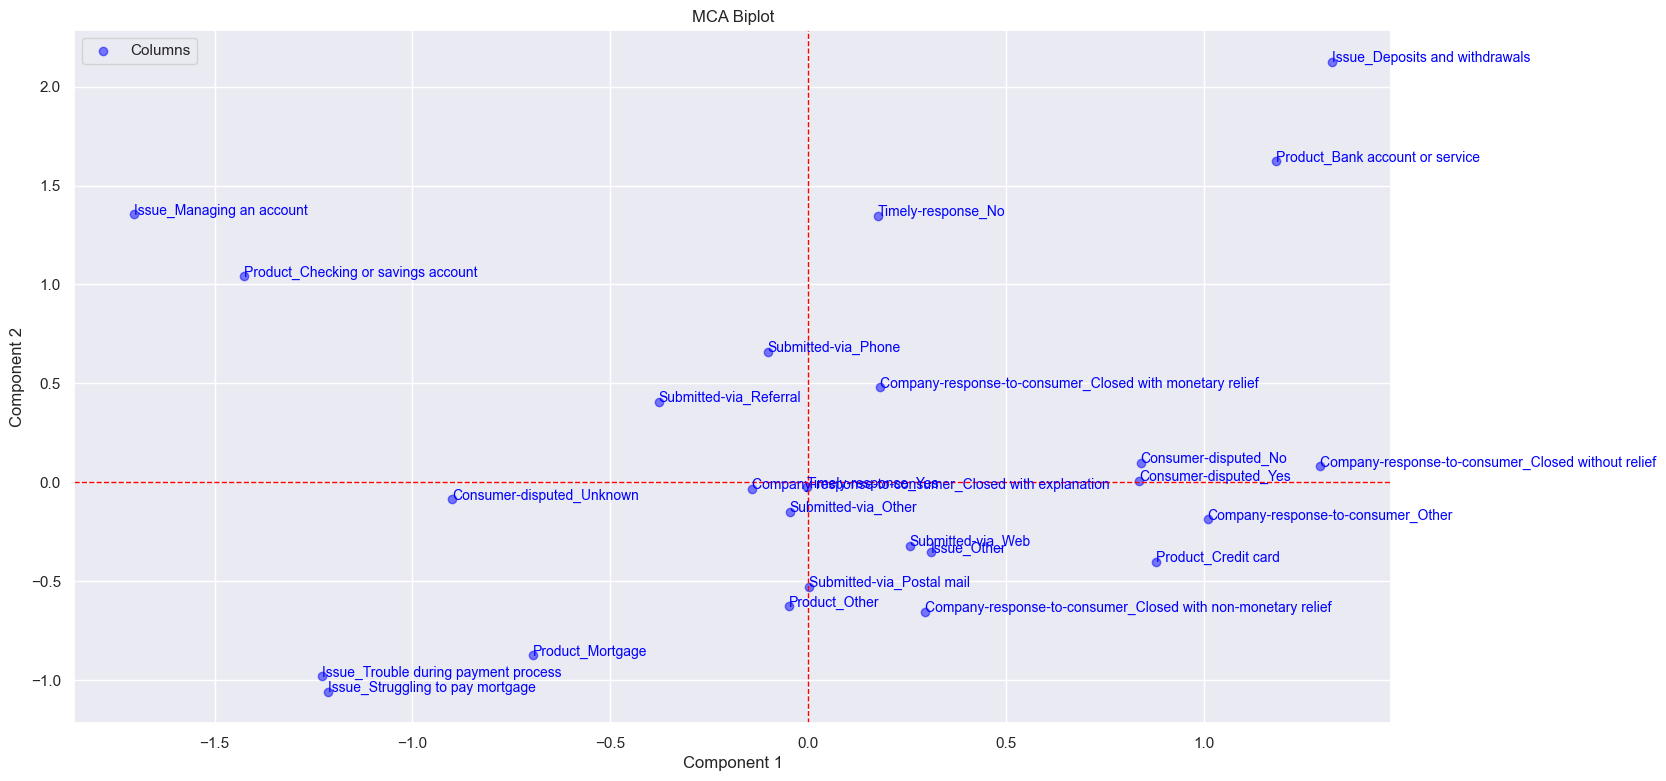

In [161]:
selected_columns_all = ['Product','Issue','Submitted-via',
                         'Company-response-to-consumer','Timely-response','Consumer-disputed']

df_filtered = filter_top_categoris(df[selected_columns_all],selected_columns_all)

plot_mca(df_filtered)

Similar Values:

“Deposits and withdrawals” and ‘Bank account or service’: The proximity of these two variables may strongly suggest that deposit/withdrawal problems are related to bank accounts.
“Managing an account” and ‘Checking or savings account’: These two issues seem to be linked. Difficulties with account management can often be linked to these product types.
Customer Feedback (Company-response-to-consumer):

“Closed with monetary relief": More similar to the categories “Submitted-via_Phone” and “Submitted-via_Referral” above. This suggests that complaints received by phone or referral may be characterized by cases resulting in monetary relief.
“Closed without relief": Seems to be related to the categories “Consumer-disputed_No” and “Consumer-disputed_Yes”. This may indicate that compensation is not provided in cases where the customer has or has not disputed.